# **Gobest Cab – Sprint 2 (CA2): ML Model for Trip Safety Prediction**
**Role:** Person A (ML Engineer)  
**Goal:** Train a machine learning model to classify trips as **Safe (0)** or **Dangerous (1)** using sensor data.

**Deliverables for Sprint 2:**
1. ML-focused EDA
2. Advanced Feature Engineering (≥10 new features, no leakage)
3. Model training + evaluation (and later deployment integration)
4. Track experiments (e.g., MLflow)


---

`WORKFLOW:`
1. Load feature-engineered dataset
2. Train-test split (stratified 80/20) → BEFORE encoding
3. Encode categoricals (fit on train, transform both)
4. Apply SMOTE to training set only
5. Log everything to MLflow
6. Save datasets

`IMPORTANT NOTES:`
   - Split BEFORE encoding (avoid test leakage)
   - MLflow tracking integrated
   - Proper encoder fitting (train only)

`MLFLOW TRACKING:` 
   - Experiment: "1_data_preparation"
   - Params: split ratio, SMOTE settings
   - Metrics: class distribution
   - Artifacts: datasets, split summary

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
import os
import pickle

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Imbalanced-learn
from imblearn.over_sampling import SMOTE

# MLflow
import mlflow
import mlflow.sklearn

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

---

**STEP 0: SETUP MLFLOW**

<mark>Initialization and MLflow Setup</mark>

- `Purpose`: To create a digital "paper trail" of our data preparation.

- `Tracking URI`: We are telling MLflow where to save the logs. Using ./mlruns creates a local folder.

- `Experiment & Run`: This organizes our work as well. If we try different SMOTE settings later, we can compare which "Run" produced the better dataset.

- `Params & Metrics`: We are logging the "input" (dataset shape) and "output" (imbalance ratio). This is vital because if our model performs strangely later, we can always look back and see exactly what data it was trained on.

In [4]:
# mlflow.set_tracking_uri("http://10.242.9.205:5000")
# mlflow.set_experiment("1_data_preparation")

# run_name = f"split_smote_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# with mlflow.start_run(run_name=run_name) as run:
#     mlflow.set_tag("mlflow.runName", run_name)

#     print("Run name:", run_name)
#     print("Run ID:", run.info.run_id)

#     # EVERYTHING below must stay indented
#     df = pd.read_pickle("datasets/trip_features_ml_advanced.pkl")
#     mlflow.log_param("input_dataset", "trip_features_ml_advanced.pkl")
#     mlflow.log_param("total_samples", df.shape[0])
#     mlflow.log_param("total_features", df.shape[1])


# Set MLflow tracking URI (local directory)
mlflow.set_tracking_uri("file:./mlruns")

# Create/set experiment
experiment_name = "1_data_preparation"
mlflow.set_experiment(experiment_name)

print(f"MLflow experiment set: '{experiment_name}'")
print(f" Tracking URI: {mlflow.get_tracking_uri()}")
print(f" Experiment ID: {mlflow.get_experiment_by_name(experiment_name).experiment_id}")

# Start MLflow run
run_name = f"split_smote_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
mlflow.start_run(run_name=run_name)

print(f"\nMLflow run started: '{run_name}'")
print(f" Run ID: {mlflow.active_run().info.run_id}")

C:\Users\gohyu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mlflow\tracking\_tracking_service\utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


MLflow experiment set: '1_data_preparation'
 Tracking URI: file:./mlruns
 Experiment ID: 796384888333859017

MLflow run started: 'split_smote_20260123_151938'
 Run ID: b250a5e781ec457aa24958a3bf7cc95a


In [5]:
# mlflow.end_run()


---

**STEP 2: LOADING DATA**

`Purpose`: Ensuring the foundation is solid before processing.

- `The "Shape" Check`: We confirm the row/column count to ensure no data was lost during the Feature Engineering export.

- `Baseline Distribution Analysis`: * The Goal: Calculate the "Baseline Accuracy" (75.03%). This is our performance floor. Any model we build must beat this number to prove it is learning patterns beyond just guessing the majority class.

    - `Imbalance Severity`: Categorizing this as "Moderate" (3:1) justifies the decision to use SMOTE later. If it were 100:1, we would need more aggressive techniques like Cost-Sensitive Learning.

In [6]:
# Load 
df = pd.read_pickle("datasets/trip_features_ml_advanced.pkl")

print("\nData loaded successfully!")
print(f"   Dataset shape: {df.shape}")
print(f"   Total trips: {df.shape[0]: ,}")

# Log to MLflow
mlflow.log_param("input_dataset", "trip_features_ml_advanced.pkl")
mlflow.log_param("total_samples", df.shape[0])
mlflow.log_param("total_features", df.shape[1])


Data loaded successfully!
   Dataset shape: (19923, 45)
   Total trips:  19,923


45

In [7]:
# Check label distribution
print(f"\nOriginal label distribution:")
label_counts = df['label'].value_counts()
print(label_counts)
print(f"   Danger rate: {df['label'].mean()*100:.2f}%")
print(f"   Imbalance ratio: {label_counts[0] / label_counts[1]:.2f}: 1")

# Log label distribution
mlflow.log_param("original_safe_count", int(label_counts[0]))
mlflow.log_param("original_danger_count", int(label_counts[1]))
mlflow.log_metric("original_danger_rate", df['label'].mean())
mlflow.log_metric("original_imbalance_ratio", label_counts[0] / label_counts[1])


Original label distribution:
label
0    14934
1     4989
Name: count, dtype: int64
   Danger rate: 25.04%
   Imbalance ratio: 2.99: 1


---

**STEP 3: ANALYZE CLASS DISTRIBUTION**

In [8]:
safe_count = label_counts[0]
danger_count = label_counts[1]
total = len(df)

imbalance_ratio = safe_count / danger_count
minority_pct = danger_count / total * 100
baseline_accuracy = safe_count / total * 100

print(f"\nCLASS COUNTS:")
print(f"   Safe (0):       {safe_count:,} ({safe_count/total*100:.2f}%)")
print(f"   Dangerous (1):  {danger_count:,} ({danger_count/total*100:.2f}%)")
print(f"   Total:          {total:,}")

print(f"\nIMBALANCE METRICS:")
print(f"   Imbalance Ratio:        {imbalance_ratio:.2f}:1")
print(f"   Minority Class %:      {minority_pct:.2f}%")
print(f"   Baseline Accuracy:      {baseline_accuracy:.2f}%")


CLASS COUNTS:
   Safe (0):       14,934 (74.96%)
   Dangerous (1):  4,989 (25.04%)
   Total:          19,923

IMBALANCE METRICS:
   Imbalance Ratio:        2.99:1
   Minority Class %:      25.04%
   Baseline Accuracy:      74.96%


In [9]:
# Severity classification
if imbalance_ratio < 1.5:
    severity = "Mild"
elif imbalance_ratio < 4:
    severity = "Moderate"
elif imbalance_ratio < 9:
    severity = "Severe"
else:
    severity = "Extreme"

print(f"   Imbalance Severity: {severity}")

   Imbalance Severity: Moderate


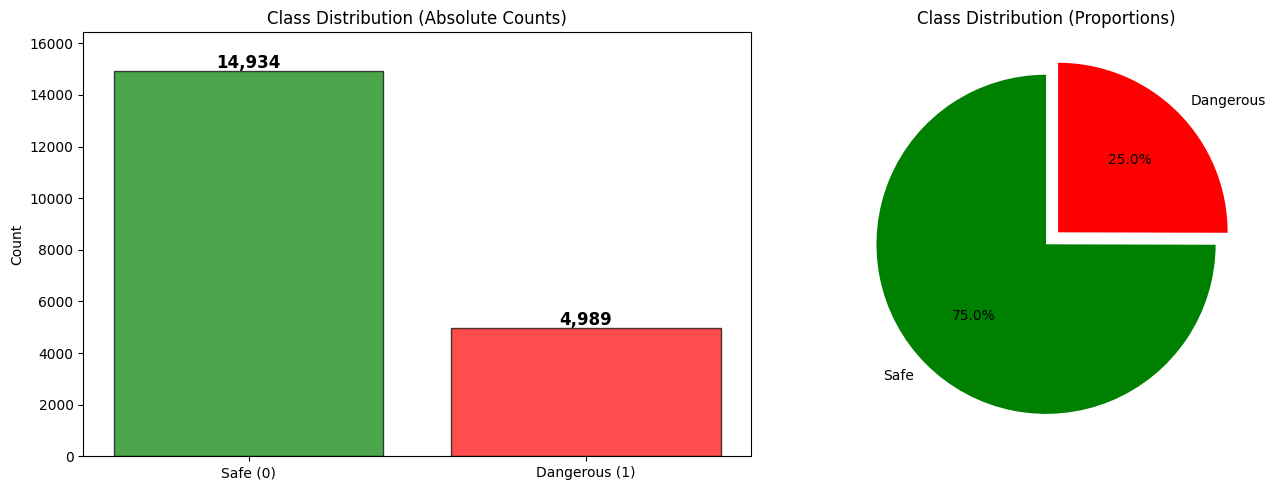

   Plot logged to MLflow


In [10]:
# Log to MLflow
mlflow.log_metric("baseline_accuracy", baseline_accuracy)
mlflow.log_param("imbalance_severity", severity)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(['Safe (0)', 'Dangerous (1)'], label_counts.values, 
            color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution (Absolute Counts)')
axes[0].set_ylim(0, safe_count * 1.1)
for i, v in enumerate(label_counts.values):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontsize=12, fontweight='bold')

colors = ['green', 'red']
axes[1].pie(label_counts.values, labels=['Safe', 'Dangerous'], autopct='%1.1f%%',
            colors=colors, startangle=90, explode=[0, 0.1])
axes[1].set_title('Class Distribution (Proportions)')

plt.tight_layout()
plt.savefig("temp_class_distribution.png", dpi=100, bbox_inches='tight')
plt.show()

# Log plot to MLflow
mlflow.log_artifact("temp_class_distribution.png", "plots")
os.remove("temp_class_distribution.png")
print("   Plot logged to MLflow")

---

**STEP 3: DATA PREPARATION**

`ORDER:`
1. Drop non-feature columns
2. Separate X and y
3. Train-test split (BEFORE encoding)
4. Save split indices
5. Encode categoricals (fit on train, handle unseen)
6. Verify all numeric

`WHY THIS ORDER?` 
- Avoids information leakage from test set
- Encoders learn only from training data
- Simulates real-world:  you don't see test data ahead of time

`Dropping ID Columns`: We remove bookingID and driver_id.

- **Importance**: These are "High Cardinality" features that carry no behavioral signal. If left in, the model might "memorize" specific IDs (Overfitting) rather than learning driving patterns.

In [11]:
import pickle

# 2.1 Drop Non-Feature Columns
print("\nRemoving non-feature columns...")

cols_to_drop = ['bookingID', 'driver_id']
print(f"Dropping:  {cols_to_drop}")

df_model = df.drop(columns=cols_to_drop)

print(f"Remaining columns: {df_model.shape[1]}")



Removing non-feature columns...
Dropping:  ['bookingID', 'driver_id']
Remaining columns: 43


In [12]:
# Log to MLflow
mlflow.log_param("columns_dropped", ",".join(cols_to_drop))
mlflow.log_param("remaining_columns", df_model.shape[1])

43

`Separating X and y`: We isolate the target (label) from the predictors (X). This is standard practice for Scikit-Learn compatibility.

`NaN Handling`: We fill any remaining missing values with 0.

   - `The Strategy`: Since we engineered features like "event counts," a NaN usually implies 0 events occurred.

In [13]:
# 2.2 Separate X and y
print("\nSeparating features (X) and target (y)...")

X = df_model.drop(columns=['label'])
y = df_model['label']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

# Log feature info
mlflow.log_param("n_features_initial", X.shape[1])

# Check for NaNs
nan_count = X.isnull().sum().sum()
if nan_count > 0:
    print(f"\nFound {nan_count} NaNs. Filling with 0...")
    X = X.fillna(0)
    mlflow.log_param("nans_filled", nan_count)
else:
    print("No NaNs in features")
    mlflow.log_param("nans_filled", 0)


Separating features (X) and target (y)...
Features (X): (19923, 42)
Target (y): (19923,)
No NaNs in features


`Why Split BEFORE Encoding?`
- This is a critical Data Leakage guardrail. If we encode using the whole dataset, the test set info "leaks" into the training set statistics. Splitting first ensures the test set remains truly independent.

- `Stratified Sampling`: We use stratify=y to ensure the 25% "Dangerous" ratio is preserved in both sets. This prevents a "lucky" split where the test set has no dangerous trips at all.

- `Reproducibility`: Saving the train_indices.csv allows us to look back at specific "misclassified" trips later for error analysis.

In [ ]:
# 2.3 TRAIN-TEST SPLIT
print("\nPerforming train-test split (stratified 80/20)...")
print("   SPLITTING BEFORE ENCODING (correct order! )")

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"\nTrain-test split complete!")
print(f"   Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Save split indices for reproducibility
print("\nSaving split indices for reproducibility...")
train_indices = pd.Series(X_train.index, name='train_index')
test_indices = pd.Series(X_test.index, name='test_index')

train_indices.to_csv("analysis/csv/train_indices.csv", index=False)
test_indices.to_csv("analysis/csv/test_indices.csv", index=False)

print(f"Saved: analysis/csv/train_indices.csv")
print(f"Saved: analysis/csv/test_indices.csv")


Performing train-test split (stratified 80/20)...
   SPLITTING BEFORE ENCODING (correct order! )

Train-test split complete!
   Training set: 15,938 samples (80.0%)
   Test set: 3,985 samples (20.0%)

Saving split indices for reproducibility...
Saved: datasets/train_indices.csv
Saved: datasets/test_indices.csv


In [15]:
# Verify stratification
print(f"\nClass distribution after split:")
train_safe = (y_train==0).sum()
train_danger = (y_train==1).sum()
test_safe = (y_test==0).sum()
test_danger = (y_test==1).sum()

print(f"   TRAINING SET:")
print(f"      Safe (0):      {train_safe:,} ({(y_train==0).mean()*100:.2f}%)")
print(f"      Dangerous (1): {train_danger:,} ({(y_train==1).mean()*100:.2f}%)")
print(f"      Ratio:         {train_safe/train_danger:.2f}: 1")

print(f"   TEST SET:")
print(f"      Safe (0):      {test_safe:,} ({(y_test==0).mean()*100:.2f}%)")
print(f"      Dangerous (1): {test_danger:,} ({(y_test==1).mean()*100:.2f}%)")
print(f"      Ratio:         {test_safe/test_danger:.2f}:1")

# Log stratification metrics
mlflow.log_metric("train_danger_rate", (y_train==1).mean())
mlflow.log_metric("test_danger_rate", (y_test==1).mean())
mlflow.log_metric("train_safe_count", train_safe)
mlflow.log_metric("train_danger_count", train_danger)
mlflow.log_metric("test_safe_count", test_safe)
mlflow.log_metric("test_danger_count", test_danger)

print("\nStratification successful (both sets maintain ~75: 25 ratio)")


Class distribution after split:
   TRAINING SET:
      Safe (0):      11,947 (74.96%)
      Dangerous (1): 3,991 (25.04%)
      Ratio:         2.99: 1
   TEST SET:
      Safe (0):      2,987 (74.96%)
      Dangerous (1): 998 (25.04%)
      Ratio:         2.99:1

Stratification successful (both sets maintain ~75: 25 ratio)


---

**STEP 4: ENCODE CATEGORICALS**

`Purpose`: Converting human-readable categories into machine-readable math.

- `Label Encoding`: We convert "Male/Female" to "1/0".

- `Handling Unseen Categories`: Our code includes a check for "UNKNOWN" values in the test set.

    - Why? In production, we might encounter a data point that wasn't in your training set. Without an "UNKNOWN" category, we model pipeline would crash.

- `Dtype Enforcement`: We force the column to int8. Many ML libraries interpret "object" columns as strings and will reject them during training.

In [16]:
def show_dist(name, s):
    vc = s.value_counts(dropna=False)
    pct = (vc / len(s) * 100).round(2)
    out = pd.DataFrame({"count": vc, "pct_%": pct})
    print(f"\n{name} (n={len(s)})")
    print(out)

# Explicitly check for known categoricals
categorical_cols = ['gender']
categorical_cols = [c for c in categorical_cols if c in X_train.columns]

if categorical_cols:
    print(f"\nCategorical columns to encode: {categorical_cols}")
    encoders = {}

    for col in categorical_cols:
        print(f"\n--- Encoding '{col}' ---")

        # BEFORE (raw)
        show_dist(f"TRAIN '{col}' BEFORE", X_train[col].astype(str))
        show_dist(f"TEST  '{col}' BEFORE", X_test[col].astype(str))

        X_train_col = X_train[col].astype(str)
        X_test_col  = X_test[col].astype(str)

        train_categories = set(X_train_col.unique())
        test_categories  = set(X_test_col.unique())
        unseen = test_categories - train_categories

        if unseen:
            print(f"\nUnseen categories in TEST for '{col}': {unseen}")
            print("   Replacing unseen with 'UNKNOWN'")
            X_test_col = X_test_col.where(X_test_col.isin(train_categories), "UNKNOWN")

        # Fit encoder on train categories + UNKNOWN (safety)
        le = LabelEncoder()
        le.fit(list(train_categories) + ["UNKNOWN"])

        # Transform
        X_train.loc[:, col] = le.transform(X_train_col)
        X_test.loc[:, col]  = le.transform(X_test_col)

        # AFTER (encoded)
        show_dist(f"TRAIN '{col}' AFTER (encoded)", X_train[col])
        show_dist(f"TEST  '{col}' AFTER (encoded)", X_test[col])

        mapping = dict(enumerate(le.classes_))
        print(f"\nMapping (encoded_value -> original_label):\n{mapping}")

        # Save encoder
        encoders[col] = le

        # Log to MLflow (optional but helpful)
        mlflow.log_param(f"encoder_{col}_classes", len(le.classes_))
        mlflow.log_param(f"encoder_{col}_mapping", str(mapping))
        mlflow.log_metric(f"{col}_test_unseen_count", int(len(unseen)))

    # Save encoders locally + log artifact
    with open("datasets/encoders.pkl", "wb") as f:
        pickle.dump(encoders, f)

    mlflow.log_artifact("datasets/encoders.pkl", "preprocessing")
    mlflow.log_param("categorical_columns_encoded", ",".join(categorical_cols))
    print("\nEncoders saved to datasets/encoders.pkl and logged to MLflow")

else:
    print("No categorical columns found to encode")
    mlflow.log_param("categorical_encoding", "none_required")



Categorical columns to encode: ['gender']

--- Encoding 'gender' ---

TRAIN 'gender' BEFORE (n=15938)
        count  pct_%
gender              
Male     8232  51.65
Female   7706  48.35

TEST  'gender' BEFORE (n=3985)
        count  pct_%
gender              
Male     2047  51.37
Female   1938  48.63

TRAIN 'gender' AFTER (encoded) (n=15938)
        count  pct_%
gender              
1        8232  51.65
0        7706  48.35

TEST  'gender' AFTER (encoded) (n=3985)
        count  pct_%
gender              
1        2047  51.37
0        1938  48.63

Mapping (encoded_value -> original_label):
{0: np.str_('Female'), 1: np.str_('Male'), 2: np.str_('UNKNOWN')}

Encoders saved to datasets/encoders.pkl and logged to MLflow


In [17]:
# recheck its datatype
print("X_train gender dtype:", X_train["gender"].dtype)
print("X_test  gender dtype:", X_test["gender"].dtype)

print("Sample train values:", X_train["gender"].head().tolist())
print("Sample test  values:", X_test["gender"].head().tolist())


X_train gender dtype: object
X_test  gender dtype: object
Sample train values: [0, 0, 0, 0, 1]
Sample test  values: [0, 1, 0, 0, 0]


In [18]:
# FORCE dtype to numeric
X_train["gender"] = X_train["gender"].astype("int8")
X_test["gender"]  = X_test["gender"].astype("int8")

print("X_train gender dtype:", X_train["gender"].dtype)
print("X_test  gender dtype:", X_test["gender"].dtype)


X_train gender dtype: int8
X_test  gender dtype: int8


---

**STEP 5: APPLY SMOTE**

`Purpose`: Forcing the model to pay equal attention to dangerous drivers.

- `The Problem`: Models are naturally "lazy"—they will prioritize the majority class (Safe) to get high accuracy.

- `The Solution`: SMOTE (Synthetic Minority Over-sampling Technique) creates new, synthetic examples of dangerous trips by interpolating between existing ones.

**Important Constraint**: We only apply SMOTE to the training set. The test set must remain imbalanced to reflect the "real world" distribution.

In [19]:
# Verify all features are numeric before SMOTE
non_numeric = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
if len(non_numeric) > 0:
    print(f"ERROR: Non-numeric columns found: {non_numeric}")
    print(" SMOTE requires all numeric features!")
    raise ValueError(f"Non-numeric columns present: {non_numeric}")
else:
    print("All features are numeric (ready for SMOTE)")
# Check for NaNs
train_nans = X_train.isnull().sum().sum()
test_nans = X_test.isnull().sum().sum()

if train_nans > 0 or test_nans > 0:
    print(f"WARNING: NaNs detected!")
    print(f"   Train: {train_nans}, Test: {test_nans}")
    print("   Filling with 0...")
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
else:
    print("No NaNs detected")

# Log verification
mlflow.log_param("pre_smote_all_numeric", True)
mlflow.log_param("pre_smote_train_nans", int(train_nans))
mlflow.log_param("pre_smote_test_nans", int(test_nans))

All features are numeric (ready for SMOTE)
No NaNs detected


0

In [20]:
# 3.1 Before SMOTE
print("\nBEFORE SMOTE (Training Set):")
train_safe_before = (y_train==0).sum()
train_danger_before = (y_train==1).sum()
train_total_before = len(y_train)
train_ratio_before = train_safe_before / train_danger_before

print(f"   Total samples:     {train_total_before:,}")
print(f"   Safe (0):        {train_safe_before:,} ({train_safe_before/train_total_before*100:.2f}%)")
print(f"   Dangerous (1):   {train_danger_before:,} ({train_danger_before/train_total_before*100:.2f}%)")
print(f"   Ratio:            {train_ratio_before:.2f}:1")

# Log pre-SMOTE stats
mlflow.log_metric("train_original_total", train_total_before)
mlflow.log_metric("train_original_safe", train_safe_before)
mlflow.log_metric("train_original_danger", train_danger_before)
mlflow.log_metric("train_original_ratio", train_ratio_before)


BEFORE SMOTE (Training Set):
   Total samples:     15,938
   Safe (0):        11,947 (74.96%)
   Dangerous (1):   3,991 (25.04%)
   Ratio:            2.99:1


In [21]:
# 3.2 Apply SMOTE

# Define SMOTE parameters (used in summary later)
SMOTE_SAMPLING_STRATEGY = 'auto'
SMOTE_K_NEIGHBORS = 5
SMOTE_RANDOM_STATE = 42

# Create SMOTE instance
smote = SMOTE(
    sampling_strategy=SMOTE_SAMPLING_STRATEGY,
    k_neighbors=SMOTE_K_NEIGHBORS,
    random_state=SMOTE_RANDOM_STATE
)

# Apply SMOTE and track time
import time
smote_start_time = time.time()

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

smote_duration = time.time() - smote_start_time

print(f"SMOTE applied successfully!  (took {smote_duration:.2f} seconds)")

# Log SMOTE params
mlflow.log_param("smote_sampling_strategy", SMOTE_SAMPLING_STRATEGY)
mlflow.log_param("smote_k_neighbors", int(SMOTE_K_NEIGHBORS))
mlflow.log_param("smote_random_state", int(SMOTE_RANDOM_STATE))
mlflow.log_metric("smote_duration_seconds", smote_duration)

SMOTE applied successfully!  (took 0.38 seconds)


In [22]:
# 3.3 After SMOTE
print("\nAFTER SMOTE (Training Set):")
train_safe_after = (y_train_smote==0).sum()
train_danger_after = (y_train_smote==1).sum()
train_total_after = len(y_train_smote)
train_ratio_after = train_safe_after / train_danger_after
synthetic_samples_created = train_danger_after - train_danger_before

print(f"   Total samples:    {train_total_after:,} (↑ {train_total_after - train_total_before:,})")
print(f"   Safe (0):        {train_safe_after:,} (unchanged)")
print(f"   Dangerous (1):   {train_danger_after:,} (↑ {synthetic_samples_created:,} synthetic)")
print(f"   Ratio:           {train_ratio_after:.2f}:1 BALANCED")

# Log post-SMOTE stats
mlflow.log_param("train_smote_total", int(train_total_after))
mlflow.log_param("synthetic_samples_created", int(synthetic_samples_created))
mlflow.log_metric("train_smote_safe", train_safe_after)
mlflow.log_metric("train_smote_danger", train_danger_after)
mlflow.log_metric("train_smote_danger_rate", train_danger_after / train_total_after)
mlflow.log_metric("train_smote_balance_ratio", train_ratio_after)


AFTER SMOTE (Training Set):
   Total samples:    23,894 (↑ 7,956)
   Safe (0):        11,947 (unchanged)
   Dangerous (1):   11,947 (↑ 7,956 synthetic)
   Ratio:           1.00:1 BALANCED



Creating SMOTE comparison visualization...


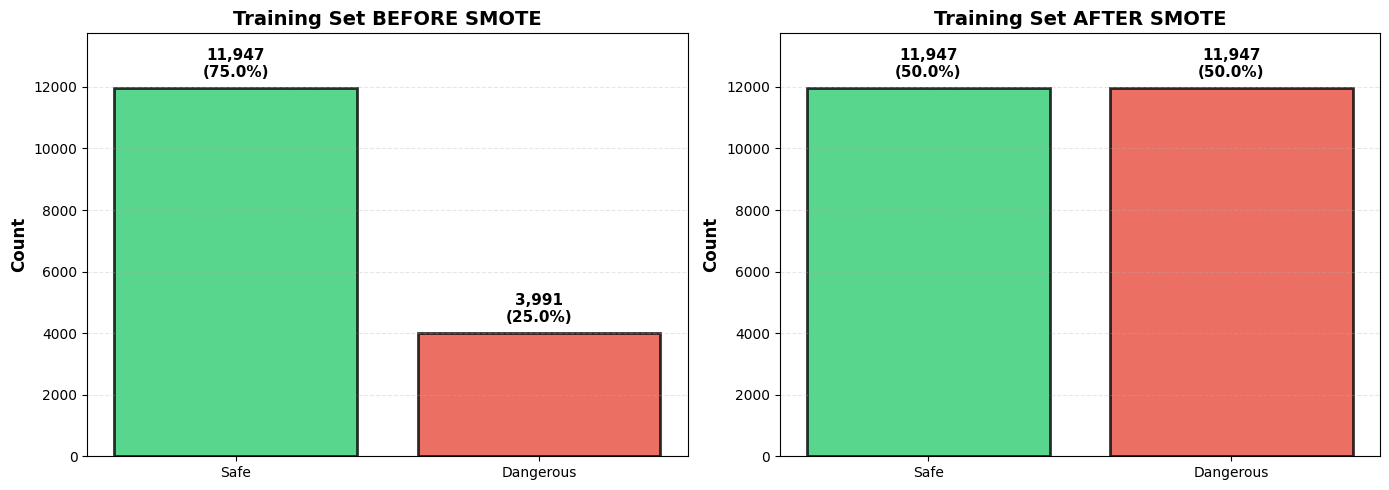

Plot logged to MLflow


In [23]:
# 3.4 Visualization
print("\nCreating SMOTE comparison visualization...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
before_counts = Counter(y_train)
axes[0].bar(['Safe', 'Dangerous'], 
            [before_counts[0], before_counts[1]],
            color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Training Set BEFORE SMOTE', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_ylim(0, max(before_counts.values()) * 1.15)

for i, (label, count) in enumerate(before_counts.items()):
    axes[0].text(i, count + max(before_counts.values())*0.03, 
                 f'{count:,}\n({count/sum(before_counts.values())*100:.1f}%)',
                 ha='center', fontsize=11, fontweight='bold')

# After SMOTE
after_counts = Counter(y_train_smote)
axes[1].bar(['Safe', 'Dangerous'], 
            [after_counts[0], after_counts[1]],
            color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1].set_title('Training Set AFTER SMOTE', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].set_ylim(0, max(after_counts.values()) * 1.15)

for i, (label, count) in enumerate(after_counts.items()):
    axes[1].text(i, count + max(after_counts.values())*0.03, 
                 f'{count:,}\n({count/sum(after_counts.values())*100:.1f}%)',
                 ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()

# Save plot temporarily
plot_filename = "temp_smote_comparison.png"
plt.savefig(plot_filename, dpi=120, bbox_inches='tight')
plt.show()

# Log to MLflow
mlflow.log_artifact(plot_filename, "visualizations")
print(f"Plot logged to MLflow")

# Clean up temporary file
os.remove(plot_filename)

---

**SAVING DATASETS**

`Purpose`: "Freezing" the data for the modeling phase.

- `Multiple Formats`: * PKL (Pickle): Preserves Python data types (like int8 or float32). Use this for training.

    - CSV: Used for human auditing and "sharing" with team members who don't use Python.

- `Metadata Logging`: Saving the feature_columns.txt ensures that when we deploy the model, we know exactly which features—and in what order—the model expects.

In [ ]:
# 4.1 Save SMOTE-Balanced Training Set
# --------------------------------------------------
print("\nSaving SMOTE-balanced training set...")

X_train_smote_df = pd.DataFrame(X_train_smote, columns=X_train.columns)
X_train_smote_df['label'] = y_train_smote.values

# Save CSV (local backup)
csv_path = "analysis/csv/X_train_smote.csv"
X_train_smote_df.to_csv(csv_path, index=False)
print(f" CSV:   {csv_path} ({X_train_smote_df.shape[0]:,} rows)")

# Save PKL (for fast loading)
pkl_path = "datasets/X_train_smote.pkl"
X_train_smote_df.to_pickle(pkl_path)
print(f"  PKL:  {pkl_path}")

#Log only PKL to MLflow (faster upload to remote server)
mlflow.log_artifact(pkl_path, "datasets")
print(f"  Logged to MLflow: X_train_smote.pkl")

# Log a sample CSV for inspection
sample_size = min(2000, len(X_train_smote_df))
sample_path = "analysis/csv/X_train_smote_sample.csv"
X_train_smote_df.head(sample_size).to_csv(sample_path, index=False)
mlflow.log_artifact(sample_path, "dataset_samples")
print(f"  Logged sample to MLflow: {sample_size} rows")


Saving SMOTE-balanced training set...
 CSV:   datasets/X_train_smote.csv (23,894 rows)
  PKL:  datasets/X_train_smote.pkl
  Logged to MLflow: X_train_smote.pkl
  Logged sample to MLflow: 2000 rows


In [ ]:
# 4.2 Save Original Training Set
print("\nSaving original training set...")

X_train_df = pd.DataFrame(X_train, columns=X_train.columns)
X_train_df['label'] = y_train.values

csv_path = "analysis/csv/X_train_original.csv"
X_train_df.to_csv(csv_path, index=False)
print(f"  CSV:  {csv_path} ({X_train_df.shape[0]:,} rows)")

pkl_path = "datasets/X_train_original.pkl"
X_train_df.to_pickle(pkl_path)
print(f"  PKL:  {pkl_path}")

# Log to MLflow
mlflow.log_artifact(pkl_path, "datasets")
print(f"  Logged to MLflow: X_train_original.pkl")


Saving original training set...
  CSV:  datasets/X_train_original.csv (15,938 rows)
  PKL:  datasets/X_train_original.pkl
  Logged to MLflow: X_train_original.pkl


In [ ]:
# 4.3 Save Test Set
print("\nSaving test set...")

X_test_df = pd.DataFrame(X_test, columns=X_test.columns)
X_test_df['label'] = y_test.values

csv_path = "analysis/csv/X_test.csv"
X_test_df.to_csv(csv_path, index=False)
print(f"  CSV:  {csv_path} ({X_test_df.shape[0]:,} rows)")

pkl_path = "datasets/X_test.pkl"
X_test_df.to_pickle(pkl_path)
print(f"  PKL:   {pkl_path}")
# Log to MLflow
mlflow.log_artifact(pkl_path, "datasets")
print(f"  Logged to MLflow: X_test.pkl")


Saving test set...
  CSV:  datasets/X_test.csv (3,985 rows)
  PKL:   datasets/X_test.pkl
  Logged to MLflow: X_test.pkl


In [ ]:
# 4.4 Save Feature Columns 
print("\nSaving feature column names...")

feature_cols = X_train.columns.tolist()

# Save as TXT
txt_path = "analysis/txt/feature_columns.txt"
with open(txt_path, 'w') as f:
    f.write('\n'.join(feature_cols))
print(f"  TXT:  {txt_path} ({len(feature_cols)} features)")

pkl_path = "datasets/feature_columns.pkl"  # Was:  "feature_columns.pkl"
with open(pkl_path, 'wb') as f:
    pickle.dump(feature_cols, f)
print(f"  PKL:  {pkl_path}")

# Log to MLflow
mlflow.log_artifact(txt_path, "metadata")
mlflow.log_artifact(pkl_path, "metadata")
print(f"  Logged to MLflow: feature_columns.txt & .pkl")

# Log feature count as param
mlflow.log_param("n_features_final", int(len(feature_cols)))



Saving feature column names...
  TXT:  datasets/feature_columns.txt (42 features)
  PKL:  datasets/feature_columns.pkl
  Logged to MLflow: feature_columns.txt & .pkl


42

In [ ]:
# 4.5 Save Split Indices (for reproducibility)
print("\nSaving split indices...")

# Already saved in Step 2, just verify
train_idx_path = "analysis/csv/train_indices.csv"
test_idx_path = "analysis/csv/test_indices.csv"

if os.path.exists(train_idx_path) and os.path.exists(test_idx_path):
    print(f"   Split indices already saved")
    # Log to MLflow
    mlflow.log_artifact(train_idx_path, "split_info")
    mlflow.log_artifact(test_idx_path, "split_info")
else:
    print(f"   Split indices not found - saving now")
    pd.Series(X_train.index, name='train_index').to_csv(train_idx_path, index=False)
    pd.Series(X_test.index, name='test_index').to_csv(test_idx_path, index=False)
    mlflow.log_artifact(train_idx_path, "split_info")
    mlflow.log_artifact(test_idx_path, "split_info")


Saving split indices...
   Split indices already saved


In [29]:
# 4.6 Save Encoders
if 'encoders' in locals() and len(encoders) > 0:
    print("\nSaving encoders...")
    encoder_path = "datasets/encoders.pkl"
    with open(encoder_path, 'wb') as f:
        pickle.dump(encoders, f)
    print(f"   Encoders saved: {list(encoders.keys())}")
    mlflow.log_artifact(encoder_path, "preprocessing")
    mlflow.log_param("encoders_saved", ",".join(encoders.keys()))
else:
    print("\n   No encoders to save")
    mlflow.log_param("encoders_saved", "none")


Saving encoders...
   Encoders saved: ['gender']


In [ ]:
# ending the program
mlflow.end_run()